In [22]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "nsl_kdd"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [23]:
import pandas as pd
import numpy as np
import umap
from matplotlib import pyplot as plt
# %matplotlib widget

import tensorflow as tf
from tensorflow.keras import layers as k_layers

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.manifold import TSNE

import time
from pprint import pprint
from data_utils import *

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

# Load data

In [24]:
RUN_ALGORITHMS = True

In [25]:
df_train = pd.read_csv(pwd + '/data/NSL-KDD/KDDTrain+.txt', header=None)
df_train

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [26]:
X_train_base, Y_train_base = df_train.iloc[:, :41].values, df_train.iloc[:, 41].values
X_train_base.shape, Y_train_base.shape

((125973, 41), (125973,))

In [27]:
df_test = pd.read_csv(pwd + '/data/NSL-KDD/KDDTest+.txt', header=None)
df_test

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21


In [28]:
X_test_base, Y_test_base = df_test.iloc[:, :41].values, df_test.iloc[:, 41].values
X_test_base.shape, Y_test_base.shape

((22544, 41), (22544,))

# Preprocessing

## Attack labels

In [29]:
attack_labels_types = {
    'normal': ['normal'],
    'DoS' : ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm'],
    'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'],
    'R2L': ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']
}

attack_labels_dict = {v: k for k, v_list in attack_labels_types.items() for v in v_list}
print(attack_labels_dict)

{'normal': 'normal', 'apache2': 'DoS', 'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'mailbomb': 'DoS', 'pod': 'DoS', 'processtable': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'udpstorm': 'DoS', 'worm': 'DoS', 'ipsweep': 'Probe', 'mscan': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'saint': 'Probe', 'satan': 'Probe', 'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'ps': 'U2R', 'rootkit': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R', 'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'httptunnel': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'named': 'R2L', 'phf': 'R2L', 'sendmail': 'R2L', 'snmpgetattack': 'R2L', 'spy': 'R2L', 'snmpguess': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L'}


In [30]:
Y_train_grouped = np.array(list(map(lambda x: attack_labels_dict[x], Y_train_base)))
Y_test_grouped = np.array(list(map(lambda x: attack_labels_dict[x], Y_test_base)))
print(Y_train_grouped)
print(Y_test_grouped)

['normal' 'normal' 'DoS' ... 'normal' 'DoS' 'normal']
['DoS' 'DoS' 'normal' ... 'DoS' 'normal' 'Probe']


In [31]:
attack_labels_base = list(set(np.unique(Y_train_grouped)) | set(np.unique(Y_test_grouped)))
attack_labels_base

['R2L', 'Probe', 'U2R', 'normal', 'DoS']

In [32]:
label_binarizer = LabelBinarizer()
label_binarizer = label_binarizer.fit(attack_labels_base)

Y_train = label_binarizer.transform(Y_train_grouped)
Y_test = label_binarizer.transform(Y_test_grouped)

Y_train.shape, Y_test.shape

((125973, 5), (22544, 5))

In [33]:
attack_classes = label_binarizer.classes_
attack_classes

array(['DoS', 'Probe', 'R2L', 'U2R', 'normal'], dtype='<U6')

In [34]:
Y_train_grouped[:10]

array(['normal', 'normal', 'DoS', 'normal', 'normal', 'DoS', 'DoS', 'DoS',
       'DoS', 'DoS'], dtype='<U6')

In [35]:
Y_train[:10]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

## Categorical features

In [36]:
categorical_features = [1, 2, 3]
numerical_features = list(set(range(X_train_base.shape[1])) - set(categorical_features))

In [37]:
one_hot_encoder = OneHotEncoder()

one_hot_encoder.fit(np.vstack([X_train_base[:, categorical_features], X_test_base[:, categorical_features]]))
one_hot_encoder.categories_

[array(['icmp', 'tcp', 'udp'], dtype=object),
 array(['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier',
        'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u',
        'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp',
        'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784',
        'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell',
        'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm',
        'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u',
        'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private',
        'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh',
        'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time',
        'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois'],
       dtype=object),
 array(['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3',
        'SF', 'SH'], dtype=object)]

In [38]:
X_train = np.hstack([X_train_base[:, numerical_features], one_hot_encoder.transform(X_train_base[:, categorical_features]).toarray()])
X_test = np.hstack([X_test_base[:, numerical_features], one_hot_encoder.transform(X_test_base[:, categorical_features]).toarray()])

X_train.shape, X_test.shape

((125973, 122), (22544, 122))

In [39]:
(X_train, X_test, Y_train, Y_test), attack_classes = load_train_test_data(pwd=pwd)

# t-SNE test

In [40]:
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])
nsl_lables = np.argmax(Y[:], axis=1)

In [41]:
def plot_2d(X_list, y, subtitles, title, figsize=(24, 7), labels=None, bbox_shift=1.15, s=15, rows=1, cols=3):
    plt.figure(figsize=figsize)
    for i, X in enumerate(X_list):
        plt.subplot(rows, cols, i + 1)
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=s)
        plt.title(subtitles[i])

    handles, classes = scatter.legend_elements()
    if labels is not None:
        classes = labels
    plt.legend(handles, classes, bbox_to_anchor=(bbox_shift, 1.02), loc='upper right')
    plt.tight_layout()
#     plt.suptitle(title)
    plt.savefig(f"{title}_default.png")

In [42]:
tsne = TSNE(n_components=2)

In [43]:
# if RUN_ALGORITHMS:
#     start = time.time()
#     X_tsne = tsne.fit_transform(X)
#     end = time.time()
#     print(f'{end - start:0.2f} s')
# else:
#     X_tsne = np.load('X_tsne.npy')    

In [44]:
# plt.figure(figsize=(8, 8))

# scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(Y[:], axis=1), s=12, cmap='tab10')

# handles, _ = scatter.legend_elements()
# plt.legend(handles, attack_classes)

# plt.show()

In [45]:
np.unique(np.argmax(Y_train, axis=1), return_counts=True)

(array([0, 1, 2, 3, 4]), array([45927, 11656,   995,    52, 67343]))

In [46]:
Y.shape

(148517, 5)

In [47]:
titles_tsne_nsl = [
#     'perplexity=5',
    'perplexity=30',
    'perplexity=80',
    'perplexity=120',
#     'perplexity=160'
]

if RUN_ALGORITHMS:
    tsne_list_nsl = [
        #TSNE(perplexity=5, n_components=2, random_state=42),
        TSNE(perplexity=30, n_components=2, random_state=42),
        TSNE(perplexity=80, n_components=2, random_state=42),
        TSNE(perplexity=120, n_components=2, random_state=42),
        #TSNE(perplexity=160, n_components=2, random_state=42)
    ]

    X_nsl_tsne = []
    for i, tsne in enumerate(tsne_list_nsl):
        print(f'Starting {titles_tsne_nsl[i]}, ', end='')
        X_nsl_tsne.append(run_and_measure(tsne.fit_transform, X))

    np.save(pwd + '/data/saved_X/X_nsl_tsne.npy', np.array(X_nsl_tsne))

else:
    X_nsl_tsne = np.load(pwd + '/data/saved_X/X_nsl_tsne.npy')

Starting perplexity=30, 538.53 s
Starting perplexity=80, 601.87 s
Starting perplexity=120, 659.90 s


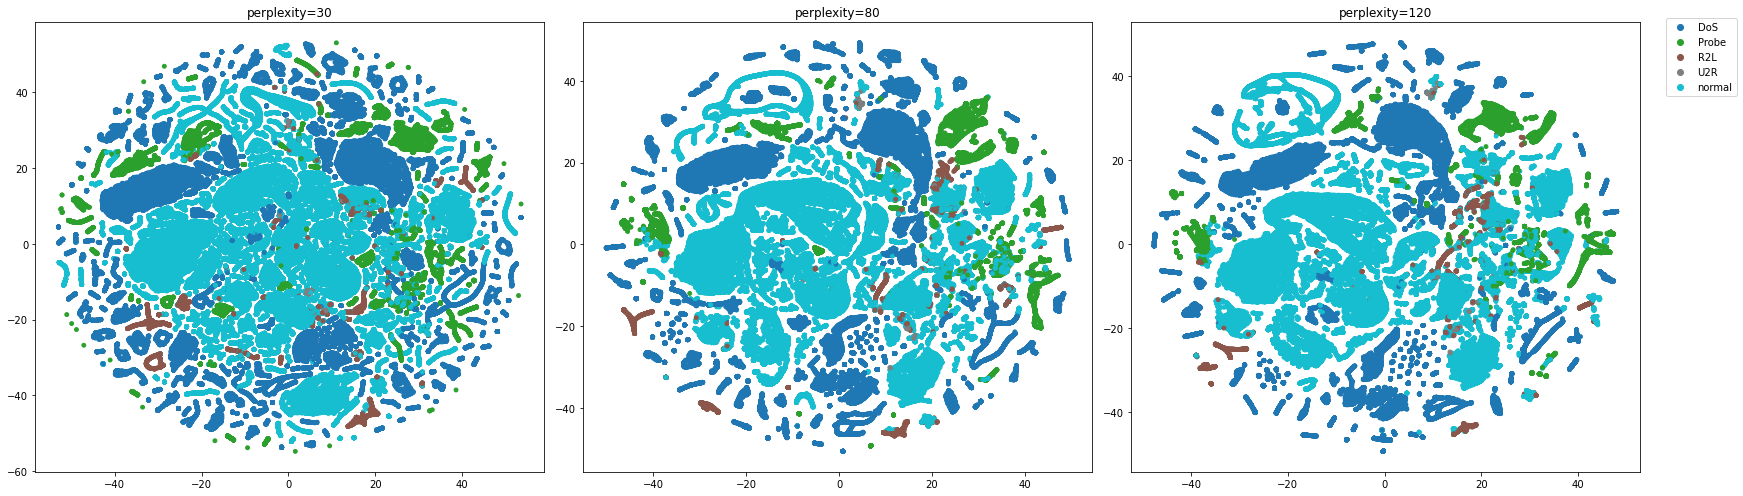

In [48]:
plot_2d(X_nsl_tsne, nsl_lables, titles_tsne_nsl, 'NSL t-SNE', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))

## UMAP


In [49]:
titles_umap_nsl = [
    'n_neighbors=15, min_dist=0.4',
    'n_neighbors=60, min_dist=0.6',
    'n_neighbors=100, min_dist=0.8',
]

if RUN_ALGORITHMS:
    umap_list_nsl = [
        umap.UMAP(n_neighbors=15, min_dist=0.4, n_components=2, random_state=42),
        umap.UMAP(n_neighbors=60, min_dist=0.6, n_components=2, random_state=42),
        umap.UMAP(n_neighbors=100, min_dist=0.8, n_components=2, random_state=42),
    ]

    X_nsl_umap = []
    for i, umap_model in enumerate(umap_list_nsl):
        print(f'Starting {titles_umap_nsl[i]}, ', end='')
        X_nsl_umap.append(run_and_measure(umap_model.fit_transform, X))

    np.save(pwd + '/data/saved_X/X_nsl_umap.npy', np.array(X_nsl_umap))

else:
    X_nsl_umap = np.load(pwd + '/data/saved_X/X_nsl_umap.npy')

Starting n_neighbors=15, min_dist=0.4, 172.44 s
Starting n_neighbors=60, min_dist=0.6, 279.99 s
Starting n_neighbors=100, min_dist=0.8, 309.46 s


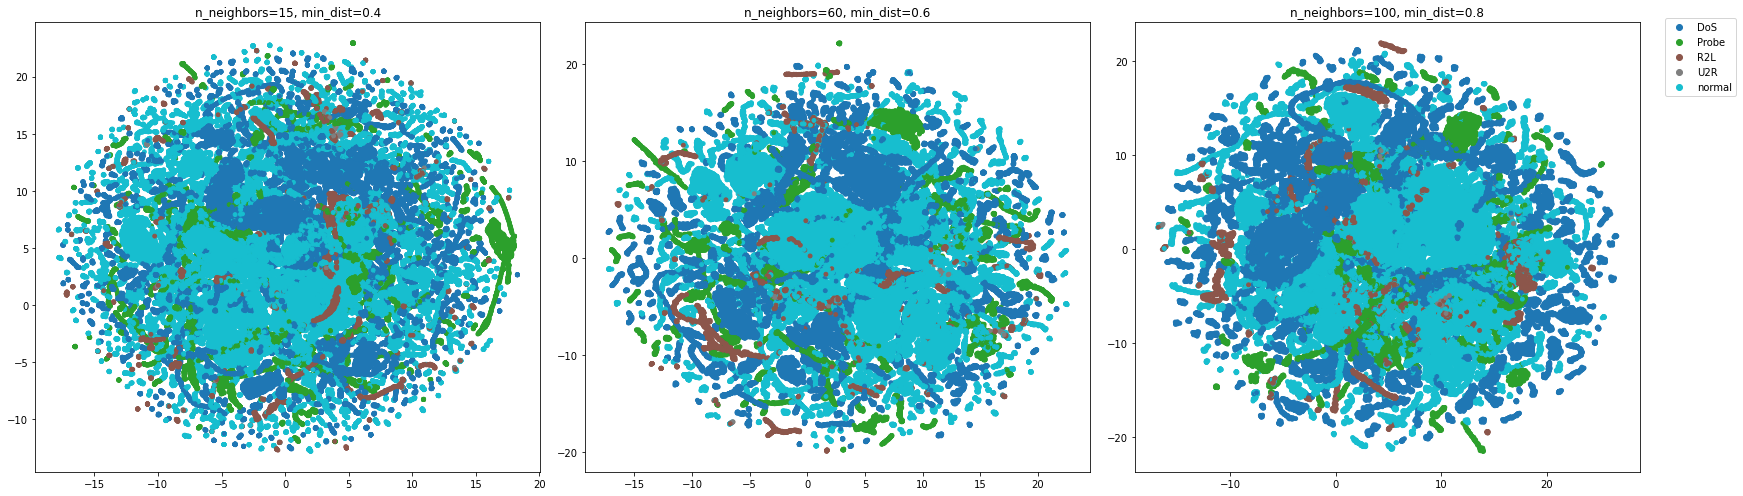

In [50]:
plot_2d(X_nsl_umap, nsl_lables, titles_umap_nsl, 'NSL UMAP', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))

## LargeVis

In [51]:
perp = [50, 75, 100]
neigh = [x*3 for x in perp]

titles_largevis_nsl = [
    #'perp=25 neigh=75',
    'perp=50 neigh=150',
    'perp=75 neigh=225',
    'perp=100 neigh=300',
    #'perp=140 neigh=420'
]
path = pwd + "/data/points/nsl_points.txt"

In [52]:
if RUN_ALGORITHMS:
    write_to_file(X, path)
    X_nsl_largevis = []
    for p,n in zip(perp, neigh):
        !./LargeVis -input ../data/points/nsl_points.txt -perp $p -neigh $n -output ../data/after_largevis/after_largevis_nsl_$p\_$n\.txt
        df = pd.read_csv(pwd + f"/data/after_largevis/after_largevis_nsl_{p}_{n}.txt", sep=' ', header=None)
        X_nsl_largevis.append(df.values[1:])
    np.save(pwd + '/data/saved_X/X_nsl_largevis.npy', np.array(X_nsl_largevis))
else:
    X_nsl_largevis = np.load(pwd + '/data/saved_X/X_nsl_largevis.npy')

zsh:1: no such file or directory: ./LargeVis
zsh:1: no such file or directory: ./LargeVis
zsh:1: no such file or directory: ./LargeVis


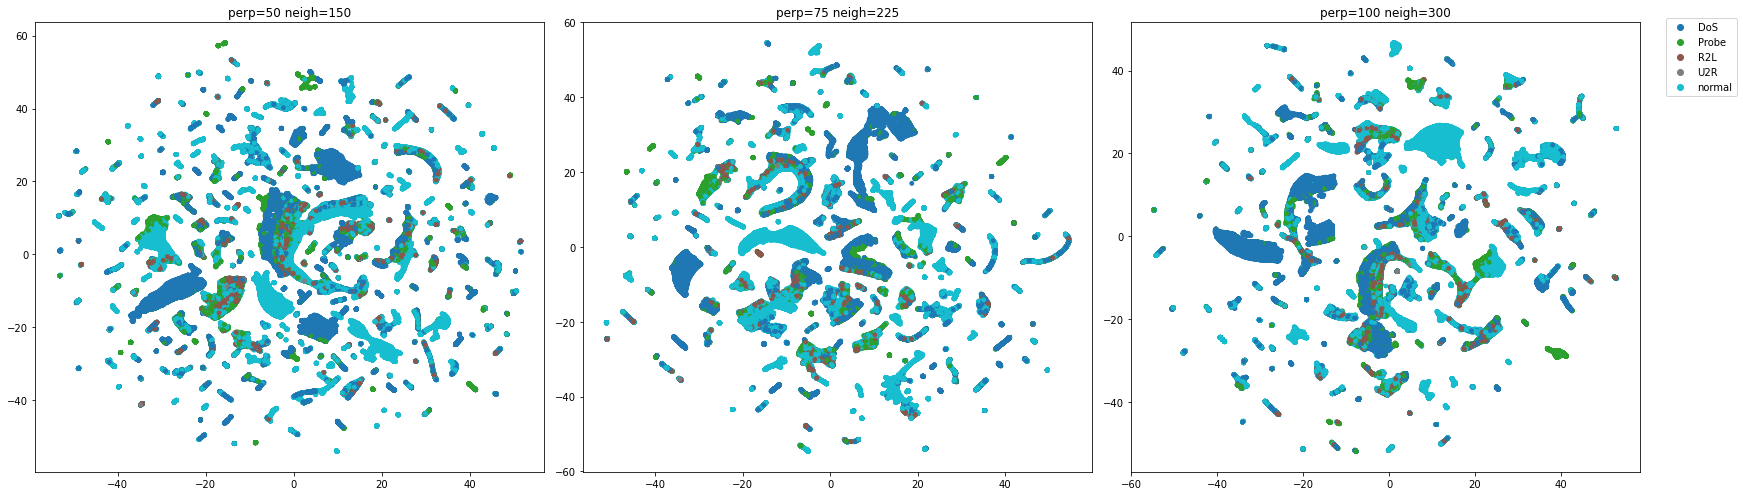

In [53]:
plot_2d(X_nsl_largevis, nsl_lables, titles_largevis_nsl, 'NSL LargeVis', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))